# First we want to import our initial data as well as the libraries we anticipate using

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

Now that we have our data read, let's go about inspecting and cleaning it.

# Data Cleaning

Let's look at the data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

From top down, several initial transformations must take place.

Date: change to date time

Waterfront: inspect NaNs (and likely drop)
Other columns that require further inspection:
    -View, Condition, Grade, Year Renovated

Sqft Basement: convert to float

In [4]:
# Date to datetime
df['date'] = pd.to_datetime(df['date'])

# Add year column
df['year'] = pd.DatetimeIndex(df['date']).year

# SQFT Basement to float
df.drop(df.loc[df['sqft_basement'] == '?'].index, inplace=True)
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [5]:
# What years are we dealing with?
df['year'].value_counts()

2014    14305
2015     6838
Name: year, dtype: int64

Now let's look at values for the other colummns to see if there's anything obvious for us to drop

First just the columns with categorical or narrowly discrete units

In [6]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year'],
      dtype='object')

In [7]:
df['bedrooms'].unique()

# Drop entry with 33 Bedrooms
df.drop(df.loc[df['bedrooms'] == 33].index, inplace=True)

df['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10])

In [8]:
df['bathrooms'].unique()

# Drop entry with 0.5 bathrooms
df.drop(df.loc[df['bathrooms'] == 0.5].index, inplace=True)

df['bathrooms'].unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 5.5 , 6.75,
       5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [9]:
df['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [10]:
# Drop NAs

df['waterfront'].unique()
df['waterfront'].value_counts(dropna=False)

NO     18658
NaN     2339
YES      142
Name: waterfront, dtype: int64

Although there are over 2,000 counts of NaN for waterfront, I feel fairly comfortable turning these NaNs to "No"s

In [11]:
# Turn NaNs to No
df['waterfront'] = df['waterfront'].fillna('NO')

# Convert to 0 or 1
mapdict = {'YES': 1, 'NO': 0}
df['waterfront'] = df['waterfront'].map(mapdict)

# Check result
df['waterfront'].value_counts(dropna=False)

0    20997
1      142
Name: waterfront, dtype: int64

In [12]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year'],
      dtype='object')

In [13]:
df['view'].value_counts()

NONE         19014
AVERAGE        930
GOOD           496
FAIR           327
EXCELLENT      311
Name: view, dtype: int64

In [14]:
# Create Yes/No column for view
df['view_y_n'] = df['view'].apply(lambda x: 0 if x == 'NONE' else 1)
df['view_y_n'].value_counts()

# Actually let's just drop view because so many are None.
df.drop(['view_y_n', 'view'], axis = 1, inplace=True)

# Let's also drop the latitude and longitude values
df.drop(['lat', 'long'], axis = 1, inplace=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21139 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21139 non-null  int64         
 1   date           21139 non-null  datetime64[ns]
 2   price          21139 non-null  float64       
 3   bedrooms       21139 non-null  int64         
 4   bathrooms      21139 non-null  float64       
 5   sqft_living    21139 non-null  int64         
 6   sqft_lot       21139 non-null  int64         
 7   floors         21139 non-null  float64       
 8   waterfront     21139 non-null  int64         
 9   condition      21139 non-null  object        
 10  grade          21139 non-null  object        
 11  sqft_above     21139 non-null  int64         
 12  sqft_basement  21139 non-null  float64       
 13  yr_built       21139 non-null  int64         
 14  yr_renovated   17385 non-null  float64       
 15  zipcode        2113

There is some data that could be understood continuously, but is currently represented by strings.

Let's transform those.

In [15]:
df['condition'].value_counts()

# Map numerical values

mapdict = {'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}
df['condition'] = df['condition'].map(mapdict)


df['condition'].value_counts()

2    13724
3     5556
4     1665
1      166
0       28
Name: condition, dtype: int64

In [16]:
df['grade'].value_counts()

7 Average        8787
8 Good           5933
9 Better         2557
6 Low Average    1995
10 Very Good     1112
11 Excellent      391
5 Fair            234
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [17]:
df['grade'] = df.grade.str.split(' ').str[0]
df['grade'] = df['grade'].astype(int)

In [18]:
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,year
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,2,7,1180,0.0,1955,0.0,98178,1340,5650,2014
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,2,7,2170,400.0,1951,1991.0,98125,1690,7639,2014
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,2,6,770,0.0,1933,NaN,98028,2720,8062,2015


# Get Metric for general property value by zipcode

Now that our data is fairly well cleaned, let's find a way to represent quality of neighborhood in our model.

In [19]:
HPI_df = pd.read_csv('data/HPI_AT_BDL_ZIP5.csv')

HPI_df.columns = HPI_df.columns.str.replace(' ', '_')

HPI_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605415 entries, 0 to 605414
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Five-Digit_ZIP_Code  605415 non-null  int64  
 1   Year                 605415 non-null  int64  
 2   Annual_Change_(%)    605415 non-null  object 
 3   HPI                  605415 non-null  object 
 4   HPI_with_1990_base   605415 non-null  object 
 5   HPI_with_2000_base   605415 non-null  object 
 6   Unnamed:_6           0 non-null       float64
 7   Unnamed:_7           0 non-null       float64
dtypes: float64(2), int64(2), object(4)
memory usage: 37.0+ MB


In [20]:
HPI_df.head(3)

,Five-Digit_ZIP_Code,Year,Annual_Change_(%),HPI,HPI_with_1990_base,HPI_with_2000_base,Unnamed:_6,Unnamed:_7
0,1001,1985,.,100.00,61.91,60.99,NaN,NaN
1,1001,1986,14.16,114.16,70.67,69.62,NaN,NaN
2,1001,1987,21.05,138.19,85.55,84.28,NaN,NaN


In [21]:
# Drop unnecessary columns

HPI_df.drop(['Annual_Change_(%)', 'Unnamed:_6', 'Unnamed:_7'], axis = 1, inplace=True)

# Rename colummns

HPI_df.rename(columns = {'Five-Digit_ZIP_Code': 'zipcode', 'Year': 'year'}, inplace=True)

In [22]:
HPI_df['year'].max()

2021

In [23]:
# Change columns to numeric

HPI_df['HPI'] = pd.to_numeric(HPI_df['HPI'], errors = 'coerce')
HPI_df['HPI_with_1990_base'] = pd.to_numeric(HPI_df['HPI_with_1990_base'], errors = 'coerce')
HPI_df['HPI_with_2000_base'] = pd.to_numeric(HPI_df['HPI_with_2000_base'], errors = 'coerce')

In [24]:
# Merge dataframes

df_merged = pd.merge(df, HPI_df, on = ['zipcode', 'year'], how='left')

In [25]:
df_merged.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,year,HPI,HPI_with_1990_base,HPI_with_2000_base
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,2,...,0.0,1955,0.0,98178,1340,5650,2014,661.52,232.95,136.93
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,2,...,400.0,1951,1991.0,98125,1690,7639,2014,1141.29,273.02,170.20
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,2,...,0.0,1933,NaN,98028,2720,8062,2015,786.52,280.44,173.73
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,4,...,910.0,1965,0.0,98136,1360,5000,2014,1232.44,290.53,171.98
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,2,...,0.0,1987,0.0,98074,1800,7503,2015,777.58,263.49,180.53


In [26]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21139 entries, 0 to 21138
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  21139 non-null  int64         
 1   date                21139 non-null  datetime64[ns]
 2   price               21139 non-null  float64       
 3   bedrooms            21139 non-null  int64         
 4   bathrooms           21139 non-null  float64       
 5   sqft_living         21139 non-null  int64         
 6   sqft_lot            21139 non-null  int64         
 7   floors              21139 non-null  float64       
 8   waterfront          21139 non-null  int64         
 9   condition           21139 non-null  int64         
 10  grade               21139 non-null  int64         
 11  sqft_above          21139 non-null  int64         
 12  sqft_basement       21139 non-null  float64       
 13  yr_built            21139 non-null  int64     

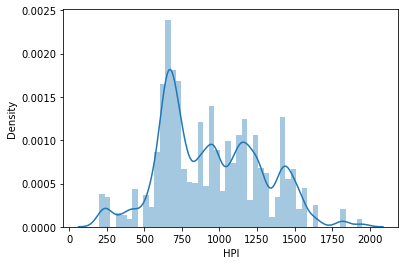

In [27]:
sns.distplot(df_merged['HPI']);

# Alternative Method

In [28]:
df_merged['zip_mean'] = df_merged.groupby('zipcode')['price'].transform('mean')
df_merged['zip_count'] = df_merged.groupby('zipcode')['zipcode'].transform('count')

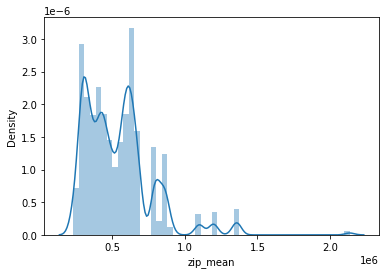

In [29]:
sns.distplot(df_merged['zip_mean']);

# Regression

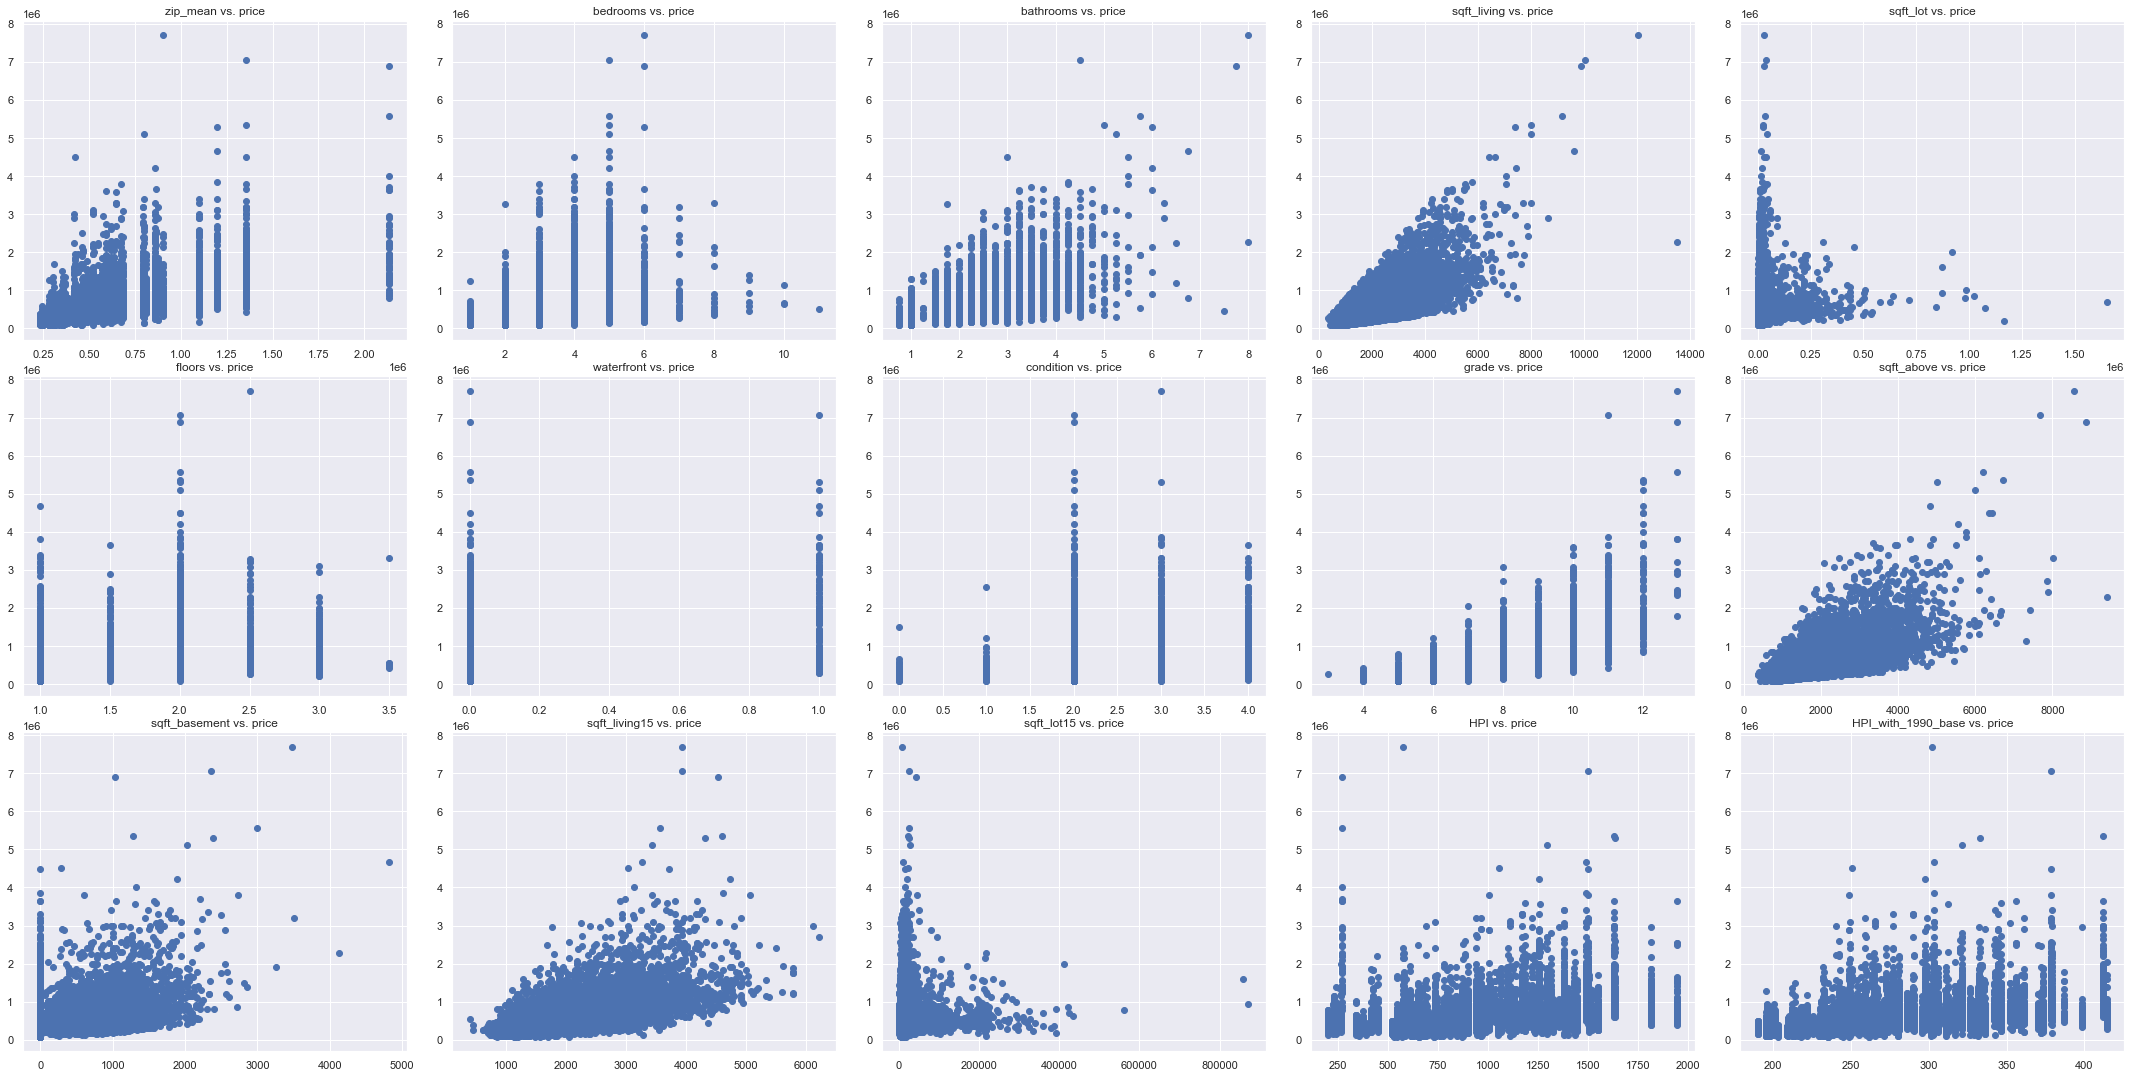

In [30]:
sns.set()

fig, axs = plt.subplots(3,5)

fig.set_figheight(15)
fig.set_figwidth(30)
plt.tight_layout()
x = df_merged.drop(columns=['price', 'date', 'id', 'yr_built', 'yr_renovated', 'zipcode', 'year', 'zip_count'])
y = df_merged['price']
column_num = 0

for w in range(3):
    for h in range(5):
        axs[w,h].scatter(x.iloc[:,(column_num-1)], y)
        axs[w,h].set_title('{} vs. {}'.format(x.columns[column_num-1], 'price'))
        column_num += 1

<AxesSubplot:>

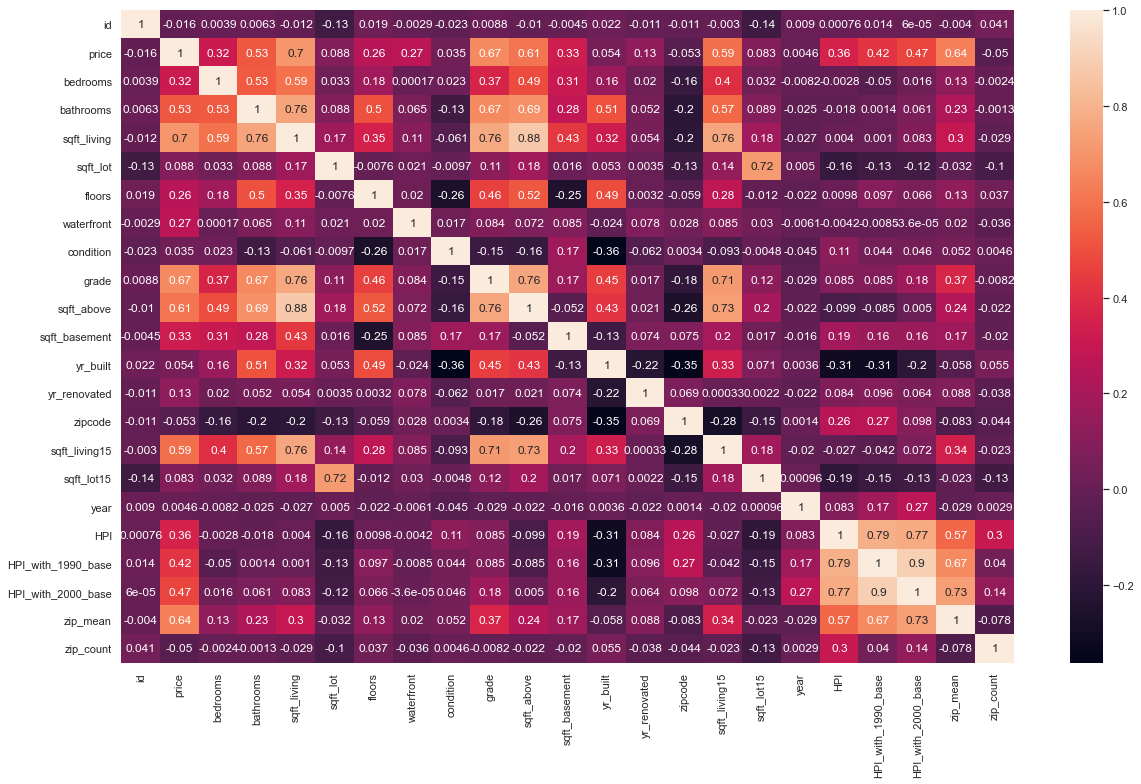

In [31]:
plt.figure(figsize=(20,12))
sns.heatmap(df_merged.corr(),annot=True)

In [32]:
columnstodrop = ['date','id','zip_count','year','HPI_with_1990_base', 'HPI_with_2000_base',
                 'zip_mean', 'floors']

df_merged = df_merged.dropna(subset=['yr_renovated'])
df_merged = df_merged.dropna(subset=['HPI'])

In [33]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17376 entries, 0 to 21138
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  17376 non-null  int64         
 1   date                17376 non-null  datetime64[ns]
 2   price               17376 non-null  float64       
 3   bedrooms            17376 non-null  int64         
 4   bathrooms           17376 non-null  float64       
 5   sqft_living         17376 non-null  int64         
 6   sqft_lot            17376 non-null  int64         
 7   floors              17376 non-null  float64       
 8   waterfront          17376 non-null  int64         
 9   condition           17376 non-null  int64         
 10  grade               17376 non-null  int64         
 11  sqft_above          17376 non-null  int64         
 12  sqft_basement       17376 non-null  float64       
 13  yr_built            17376 non-null  int64     

# Method 1

In [34]:
y = df_merged['price']
x = sm.add_constant(df_merged.drop(columns=columnstodrop).drop(columns=['price', 'zipcode']))

In [35]:
model = sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     3329.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:36:06   Log-Likelihood:            -2.3653e+05
No. Observations:               17376   AIC:                         4.731e+05
Df Residuals:                   17362   BIC:                         4.732e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.242e+06   1.48e+05     21.916      0.000    2.95e+06    3.53e+06
bedrooms      -4.628e+04   2153.671    -21.487      0.000   -5.05e+04   -4.21e+04
bathrooms      4.017e+04   3449.768     11.644      0.000    3.34e+04    4.69e+04
sqft_living     123.5386      2.475     49.915      0.000     118.687     128.390
sqft_lot          0.1432      0.051      2.799      0.005       0.043       0.243
waterfront     8.251e+05   1.86e+04     44.357      0.000    7.89e+05    8.62e+05
condition      2.103e+04   2533.237      8.302      0.000    1.61e+04     2.6e+04
grade          8.077e+04   2384.241     33.875      0.000    7.61e+04    8.54e+04
sqft_above       81.5462      2.273     35.878      0.000      77.091      86.001
sqft_basement    41.9924      2.572     16.328      0.000      36.951      47.033
yr_built      -2080.6300     75.767    -27.461      0.000   -2229.141   -1932.119
yr_renovated     21.7672      4.020      5.414      0.000      13.887      29.648
sqft_living15    37.5135      3.618     10.370      0.000      30.423      44.605
sqft_lot15       -0.0825      0.079     -1.040      0.298      -0.238       0.073
HPI             319.9928      5.084     62.941      0.000     310.028     329.958
==============================================================================
Omnibus:                    16524.230   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2465784.819
Skew:                           4.174   Prob(JB):                         0.00
Kurtosis:                      60.759   Cond. No.                     1.50e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.04e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
model.rsquared

0.7136806392753337

In [37]:
x_standard = x.apply(lambda x: (x - x.mean())/x.std())
x_standard = x_standard.drop(columns = ['const'])
x_standard = sm.add_constant(x_standard)

y_standard = (y - y.mean())/y.std()

In [38]:
results_stand = sm.OLS(y_standard,x_standard).fit()
results_stand.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     3091.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:36:06   Log-Likelihood:                -13790.
No. Observations:               17376   AIC:                         2.761e+04
Df Residuals:                   17361   BIC:                         2.773e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.602e-18      0.004   6.41e-16      1.000      -0.008       0.008
bedrooms         -0.1166      0.007    -16.678      0.000      -0.130      -0.103
bathrooms         0.0849      0.007     11.401      0.000       0.070       0.100
sqft_living    2.661e+11   3.69e+11      0.721      0.471   -4.58e+11     9.9e+11
sqft_lot          0.0163      0.006      2.781      0.005       0.005       0.028
waterfront        0.1829      0.004     44.358      0.000       0.175       0.191
condition         0.0372      0.004      8.317      0.000       0.028       0.046
grade             0.2563      0.008     33.845      0.000       0.241       0.271
sqft_above    -2.398e+11   3.33e+11     -0.721      0.471   -8.92e+11    4.12e+11
sqft_basement -1.286e+11   1.79e+11     -0.721      0.471   -4.79e+11    2.21e+11
yr_built         -0.1651      0.006    -27.425      0.000      -0.177      -0.153
yr_renovated      0.0235      0.004      5.426      0.000       0.015       0.032
sqft_living15     0.0695      0.007     10.354      0.000       0.056       0.083
sqft_lot15       -0.0062      0.006     -1.048      0.294      -0.018       0.005
HPI               0.2925      0.005     62.943      0.000       0.283       0.302
==============================================================================
Omnibus:                    16515.216   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2460116.639
Skew:                           4.170   Prob(JB):                         0.00
Kurtosis:                      60.692   Cond. No.                     2.81e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.03e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [39]:
lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(x_standard, y_standard, test_size=0.2)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
MAE = round(mean_absolute_error(y_pred, y_test),2) 
score = round(lr.score(X_train, y_train),2)
print('R^2 value: {}, absolute mean error: {}'.format(score,MAE))

R^2 value: 0.71, absolute mean error: 0.33


In [40]:
df_dropped = df_merged.drop(columns=columnstodrop)

correlation_matrix = df_dropped.drop(columns='zipcode').corr()
correlation_matrix

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,HPI
price,1.000000,0.315336,0.525164,0.703853,0.086445,0.270673,0.031500,0.664560,0.607672,0.323414,0.051513,0.126344,0.584660,0.082469,0.358109
bedrooms,0.315336,1.000000,0.526930,0.592357,0.031025,-0.000776,0.016767,0.365358,0.490662,0.310858,0.159970,0.019365,0.404053,0.030209,0.002056
bathrooms,0.525164,0.526930,1.000000,0.753383,0.085416,0.066151,-0.131278,0.664964,0.685590,0.280644,0.506950,0.050322,0.570211,0.086426,-0.018287
sqft_living,0.703853,0.592357,0.753383,1.000000,0.167830,0.110262,-0.066265,0.764360,0.875766,0.436349,0.317518,0.053235,0.758065,0.181053,0.005986
sqft_lot,0.086445,0.031025,0.085416,0.167830,1.000000,0.023816,-0.011020,0.108961,0.175763,0.019581,0.048943,0.003531,0.143121,0.718215,-0.163102
waterfront,0.270673,-0.000776,0.066151,0.110262,0.023816,1.000000,0.016153,0.081404,0.075777,0.086856,-0.021170,0.077927,0.088951,0.027887,-0.010599
condition,0.031500,0.016767,-0.131278,-0.066265,-0.011020,0.016153,1.000000,-0.151560,-0.161990,0.164852,-0.366591,-0.061702,-0.097459,-0.005348,0.111403
grade,0.664560,0.365358,0.664964,0.764360,0.108961,0.081404,-0.151560,1.000000,0.757899,0.168575,0.445427,0.016208,0.717152,0.119316,0.085636
sqft_above,0.607672,0.490662,0.685590,0.875766,0.175763,0.075777,-0.161990,0.757899,1.000000,-0.052215,0.423323,0.019767,0.731867,0.190859,-0.097855
sqft_basement,0.323414,0.310858,0.280644,0.436349,0.019581,0.086856,0.164852,0.168575,-0.052215,1.000000,-0.132188,0.073283,0.204074,0.018800,0.194776


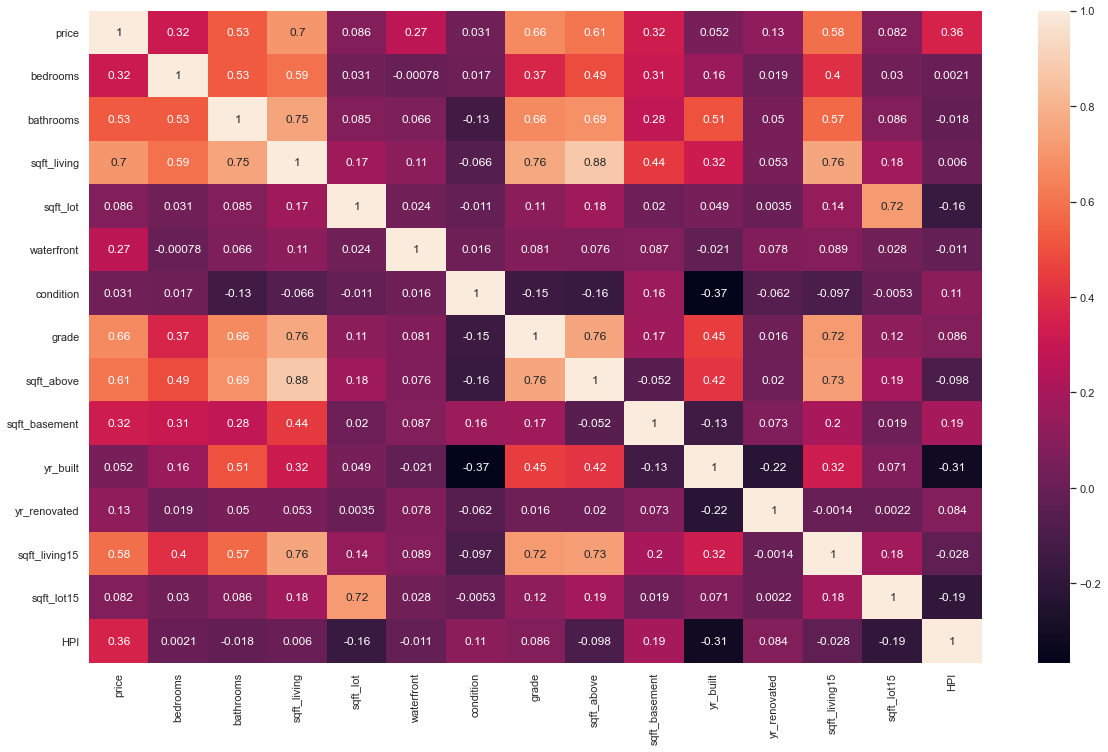

In [41]:
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix,annot=True);

In [42]:
correlation_matrix.apply(lambda x: abs(x))

correlation_matrix['sum'] = correlation_matrix[list(correlation_matrix.columns)].sum(axis=1)

correlation_matrix

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,HPI,sum
price,1.000000,0.315336,0.525164,0.703853,0.086445,0.270673,0.031500,0.664560,0.607672,0.323414,0.051513,0.126344,0.584660,0.082469,0.358109,5.731713
bedrooms,0.315336,1.000000,0.526930,0.592357,0.031025,-0.000776,0.016767,0.365358,0.490662,0.310858,0.159970,0.019365,0.404053,0.030209,0.002056,4.264169
bathrooms,0.525164,0.526930,1.000000,0.753383,0.085416,0.066151,-0.131278,0.664964,0.685590,0.280644,0.506950,0.050322,0.570211,0.086426,-0.018287,5.652588
sqft_living,0.703853,0.592357,0.753383,1.000000,0.167830,0.110262,-0.066265,0.764360,0.875766,0.436349,0.317518,0.053235,0.758065,0.181053,0.005986,6.653752
sqft_lot,0.086445,0.031025,0.085416,0.167830,1.000000,0.023816,-0.011020,0.108961,0.175763,0.019581,0.048943,0.003531,0.143121,0.718215,-0.163102,2.438526
waterfront,0.270673,-0.000776,0.066151,0.110262,0.023816,1.000000,0.016153,0.081404,0.075777,0.086856,-0.021170,0.077927,0.088951,0.027887,-0.010599,1.893314
condition,0.031500,0.016767,-0.131278,-0.066265,-0.011020,0.016153,1.000000,-0.151560,-0.161990,0.164852,-0.366591,-0.061702,-0.097459,-0.005348,0.111403,0.287461
grade,0.664560,0.365358,0.664964,0.764360,0.108961,0.081404,-0.151560,1.000000,0.757899,0.168575,0.445427,0.016208,0.717152,0.119316,0.085636,5.808259
sqft_above,0.607672,0.490662,0.685590,0.875766,0.175763,0.075777,-0.161990,0.757899,1.000000,-0.052215,0.423323,0.019767,0.731867,0.190859,-0.097855,5.722886
sqft_basement,0.323414,0.310858,0.280644,0.436349,0.019581,0.086856,0.164852,0.168575,-0.052215,1.000000,-0.132188,0.073283,0.204074,0.018800,0.194776,3.097660


# Method 2

In [43]:
columnstodrop2 = ['sqft_above', 'sqft_living15', 'yr_renovated', 'sqft_basement', 'sqft_lot15']


y = df_dropped['price']
x = sm.add_constant(df_dropped.drop(columns=columnstodrop2).drop(columns=['price','zipcode']))

In [44]:
x_standard = x.apply(lambda x: (x - x.mean())/x.std())
x_standard = x_standard.drop(columns = ['const'])
x_standard = sm.add_constant(x_standard)

y_standard = (y - y.mean())/y.std()

results_stand = sm.OLS(y_standard,x_standard).fit()
results_stand.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     4715.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:36:07   Log-Likelihood:                -13912.
No. Observations:               17376   AIC:                         2.784e+04
Df Residuals:                   17366   BIC:                         2.792e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.602e-18      0.004   6.36e-16      1.000      -0.008       0.008
bedrooms       -0.1151      0.005    -21.717      0.000      -0.126      -0.105
bathrooms       0.0800      0.007     11.269      0.000       0.066       0.094
sqft_living     0.5143      0.008     61.128      0.000       0.498       0.531
sqft_lot        0.0143      0.004      3.375      0.001       0.006       0.023
waterfront      0.1830      0.004     44.188      0.000       0.175       0.191
condition       0.0280      0.004      6.345      0.000       0.019       0.037
grade           0.2983      0.007     42.039      0.000       0.284       0.312
yr_built       -0.1667      0.006    -29.201      0.000      -0.178      -0.156
HPI             0.2809      0.005     61.312      0.000       0.272       0.290
==============================================================================
Omnibus:                    16079.993   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2177495.481
Skew:                           4.012   Prob(JB):                         0.00
Kurtosis:                      57.251   Cond. No.                         4.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x_standard, y_standard, test_size=0.2)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
MAE = round(mean_absolute_error(y_pred, y_test),2) 
score = round(lr.score(X_train, y_train),2)
print('R^2 value: {}, absolute mean error: {}'.format(score,MAE))

R^2 value: 0.71, absolute mean error: 0.34


In [46]:
y = df_dropped['price']
x = sm.add_constant(df_dropped.drop(columns=columnstodrop2).drop(columns=['price','zipcode','grade']))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

MAE = round(mean_absolute_error(y_pred, y_test),2) 

In [47]:
# Test input

a = [[1,3,2.5,2000,5000,0,3,1980,700]]

In [48]:
lr.predict(a)

array([459839.30312925])

In [49]:
df_dropped.drop(columns=columnstodrop2).head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,condition,grade,yr_built,zipcode,HPI
0,221900.0,3,1.00,1180,5650,0,2,7,1955,98178,661.52
1,538000.0,3,2.25,2570,7242,0,2,7,1951,98125,1141.29
3,604000.0,4,3.00,1960,5000,0,4,7,1965,98136,1232.44


In [50]:
df_dropped.drop(columns=columnstodrop2)['condition'].value_counts()

2    11284
3     4543
4     1387
1      140
0       22
Name: condition, dtype: int64

In [51]:
working = HPI_df[HPI_df['year'] == 2021].drop(columns = ['HPI_with_2000_base', 'HPI_with_1990_base', 'year'])
working.rename(columns = {'HPI': 'HPI_2021'}, inplace=True)
working.set_index('zipcode', inplace=True)
HPI_dict = working.to_dict()['HPI_2021']

waterfrontmap = {'YES': 1, 'Yes': 1, 'yes': 1, 'NO': 0, 'No': 0, 'no': 0}

In [52]:
def get_home_info():
    HPI = HPI_dict[int(input("What's your zipcode? "))]
    bedrooms = float(input("How many bedrooms does your home have? "))
    bathrooms = float(input("How many bathrooms does your home have? "))
    yr_built = int(input("What year was your home built? "))
    waterfront = waterfrontmap[input("Is your home on the waterfront? (YES/NO) ")]
    sqft_living = int(input("What is the square footage of your home's living area? (in ft) "))
    sqft_lot = int(input("What is the square footage of your lot? (in ft) "))
    condition = int(input("What condition would you say your home is in? (On a scale of 1-5) ")) - 1
    a = [[1, bedrooms, bathrooms, sqft_living, sqft_lot, waterfront, condition, yr_built, HPI]]
#     MAE = round(mean_absolute_error(y_pred, y_test),2) 

    print ("\n The estimated value of your home is $",int(lr.predict(a)))

In [53]:
# Estimate 1
# get_home_info()

In [54]:
# Estimate 2
# get_home_info()

In [55]:
# Estimate 2
# get_home_info()

In [56]:
# Estimate 3
# get_home_info()

In [57]:
# Estimate 3
# get_home_info()

In [58]:
import ipywidgets as widgets



